# PAGA

Running PAGA for pseudotime + trajectories. Python 3 (singlecell env).

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
from collections import Counter

### Cluster Config

In [195]:
cluster_config = pd.read_csv("../../figures_factory/configs/cluster.tsv", sep='\t')
cluster_config

,cluster,colour,description,new_cluster
0,1,#A6D854,Pre-iPSC,14
1,2,#F0A118,Intermediate,12
2,3,#E85F6D,Fibroblast-like,3
3,4,#006658,Neural-like,8
4,5,#B03743,Fibroblast,1
5,6,#CF175A,Fibroblast-like,4
6,7,#78A824,Pre-iPSC,13
7,8,#F4D5CD,Intermediate,11
8,9,#D4B81C,Intermediate,9
9,10,#F01D35,Fibroblast-like,5


## Data

In [196]:
features = pd.read_csv("../20200206_pmat_snapATAC/sessions/20201022_n53906/features.8d.tsv", sep='\t')
features.head()

,sample_barcode,X1,X2,X3,X4,X5,X6,X7,X8
0,D0_AACGCGAGAAGGACCA,0.009760,-0.002904,0.005951,-0.004448,0.005509,-0.024186,-0.005331,-0.004720
1,D0_AACGCGCTGTCTGTGA,0.010015,-0.000998,0.004592,0.000145,-0.007156,0.000794,-0.012955,-0.008187
2,D0_ACCTATGGACTCGATA,0.007804,-0.001924,0.006072,0.001319,-0.003378,-0.003462,-0.008738,-0.007855
3,D0_ACGCAGAGATAACCCA,0.010130,-0.002358,0.005915,-0.001093,-0.002407,-0.013715,-0.008480,-0.007838
4,D0_ACTCGCTACTTGTGAC,0.011737,-0.003796,0.005869,-0.001517,-0.006040,-0.005928,-0.014611,-0.001411


In [197]:
metaData = pd.read_csv("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", sep='\t')
metaData.head()

,barcode,sample,umap1,umap2,cluster
0,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5
1,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5
2,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5
3,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5
4,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5


In [202]:
adata = sc.AnnData(shape=(features.shape[0], 8))
adata

AnnData object with n_obs × n_vars = 53906 × 8

In [203]:
# feature representation
adata.obsm['X_diff'] = np.array(features.iloc[:, 1:])

# temporarily set X to X_diff also (downstream stuff doesn't work otherwise)
adata.X = adata.obsm['X_diff']

In [204]:
# use precomputed umap for consistency
adata.obsm['X_umap'] = np.array(metaData[["umap1", "umap2"]])

In [205]:
# new cluster labels
adata.obs["new_cluster"] = [str(x) for x in cluster_config.iloc[metaData['cluster']-1]["new_cluster"]]

In [206]:
adata

AnnData object with n_obs × n_vars = 53906 × 8
    obs: 'new_cluster'
    obsm: 'X_diff', 'X_umap'

In [207]:
# TEMP (Remove potential doublet cell states)
# adata = adata[~adata.obs['new_cluster'].isin(['10', '17', '18'])]

In [208]:
# set back adata.X to None
# adata.X = None  # Doesn't work

... storing 'new_cluster' as categorical


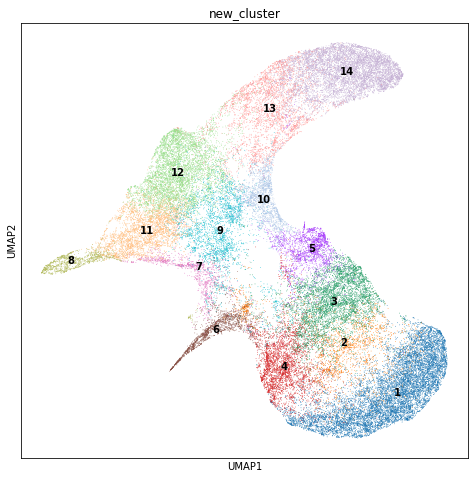

In [209]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color="new_cluster", legend_loc='on data')

## Trajectory

In [210]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diff')

In [211]:
sc.tl.paga(adata, groups='new_cluster')

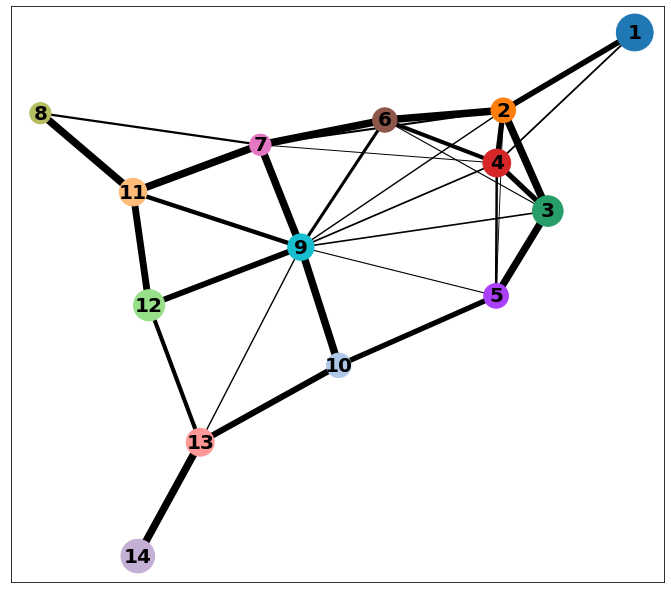

In [212]:
rcParams['figure.figsize'] = 10, 10

sc.pl.paga(adata, 
           threshold=.1, 
           fontsize=20, 
           node_size_scale=5,
#            solid_edges='connectivities_tree',
           show=True)

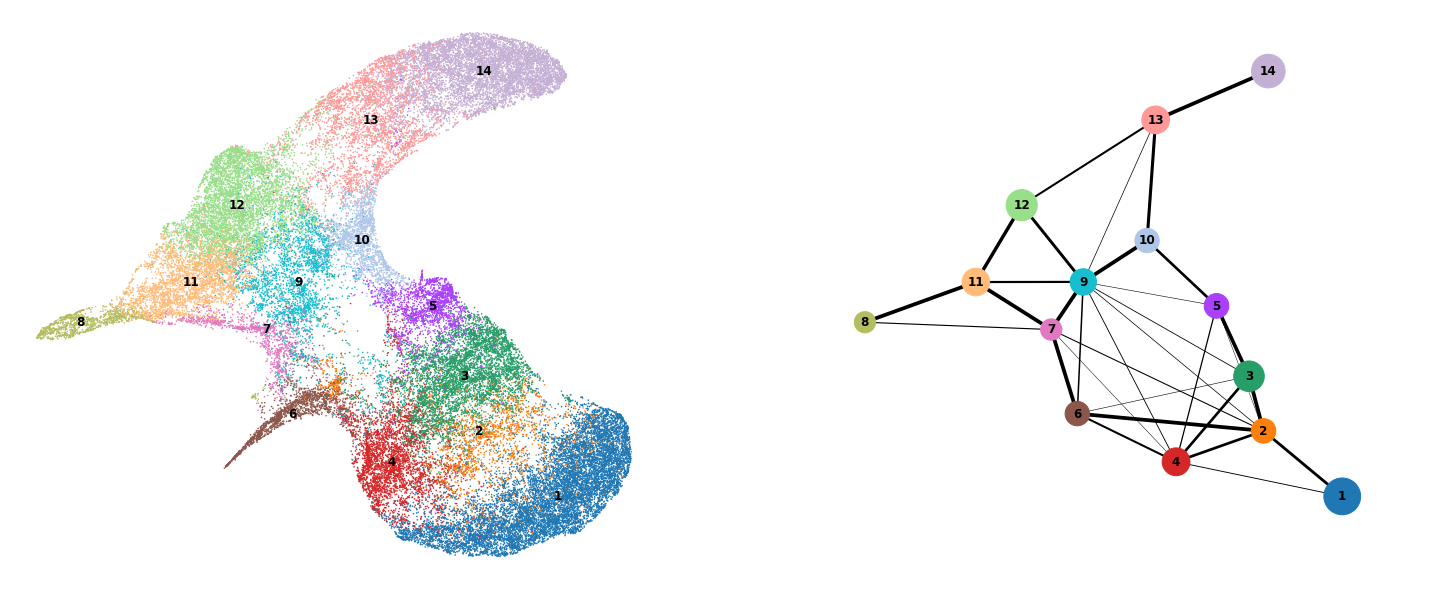

In [213]:
sc.pl.paga_compare(
    adata, threshold=0.1, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, frameon=False, edges=False, save=True,
    fontsize=20, 
    node_size_scale=5)

### Pseudotime

In [214]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['new_cluster']  == '1')[0]
adata.uns['iroot']

0

In [215]:
# re-running diffmaps though these features are diffmap outputs
# is required for dpt
sc.tl.diffmap(adata)

# can also set X_diffmap equal to X_diff
# but pseudotime is worse
# adata.obsm['X_diffmap'] = adata.obsm['X_diff']

In [216]:
sc.tl.dpt(adata)

# if using X_diff
# sc.tl.dpt(adata, n_dcs=9)

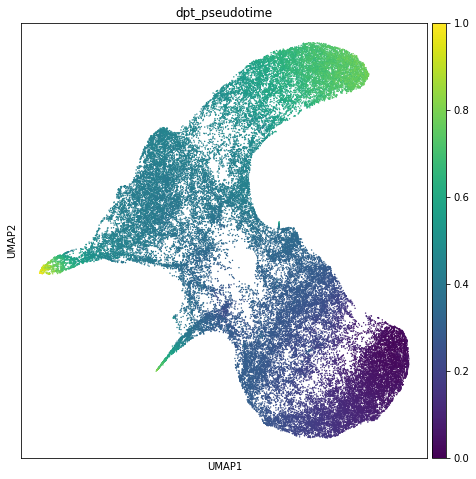

In [217]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color=['dpt_pseudotime'], 
           size=8, 
           legend_loc='on data')

## Write Session Outputs

Currently unused.

In [222]:
SESH_NAME = "20201022_n{}".format(adata.shape[0])
SESH_NAME

'20201022_n53906'

In [231]:
(conn>0.2).sum().sum()

52

In [223]:
# write PAGA connectivities matrix
conn = pd.DataFrame(adata.uns['paga']['connectivities'].todense(), 
                    index=[f'c{x}' for x in adata.obs['new_cluster'].dtype.categories],
                    columns=[f'c{x}' for x in adata.obs['new_cluster'].dtype.categories])
conn

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14
c1,0.000000,0.753016,0.054199,0.239404,0.003970,0.007201,0.002716,0.000000,0.000490,0.000000,0.000000,0.000000,0.000000,0.000000
c2,0.753016,0.000000,1.000000,0.717189,0.119324,1.000000,0.282384,0.076655,0.188704,0.000000,0.003855,0.003757,0.000499,0.000000
c3,0.054199,1.000000,0.000000,0.704112,0.963534,0.151169,0.017405,0.003078,0.216762,0.007214,0.014277,0.010917,0.001042,0.000582
c4,0.239404,0.717189,0.704112,0.000000,0.332325,0.541837,0.129278,0.003136,0.231833,0.027655,0.002812,0.006755,0.000606,0.000212
c5,0.003970,0.119324,0.963534,0.332325,0.000000,0.088986,0.011956,0.002886,0.148852,0.707201,0.002516,0.012564,0.068604,0.021135
c6,0.007201,1.000000,0.151169,0.541837,0.088986,0.000000,1.000000,0.079892,0.405807,0.001740,0.005837,0.011473,0.001802,0.000120
c7,0.002716,0.282384,0.017405,0.129278,0.011956,1.000000,0.000000,0.300065,1.000000,0.000742,1.000000,0.022621,0.001319,0.000409
c8,0.000000,0.076655,0.003078,0.003136,0.002886,0.079892,0.300065,0.000000,0.003896,0.000000,1.000000,0.013017,0.001353,0.000000
c9,0.000490,0.188704,0.216762,0.231833,0.148852,0.405807,1.000000,0.003896,0.000000,1.000000,0.581990,0.779669,0.186441,0.000964
c10,0.000000,0.000000,0.007214,0.027655,0.707201,0.001740,0.000742,0.000000,1.000000,0.000000,0.000531,0.053536,0.821116,0.000600


In [224]:
conn.to_csv(f"./sessions/{SESH_NAME}/connectivities.tsv", sep='\t')

In [257]:
# write umap coordinates, pseudotime, sample, cluster for downstream analysis
metadata = pd.DataFrame({'sample_barcode':list(features["sample_barcode"]), 
                         'dpt_pseudotime':list(adata.obs["dpt_pseudotime"])})
metadata.head()

,sample_barcode,dpt_pseudotime
0,D0_AACGCGAGAAGGACCA,0.000000
1,D0_AACGCGCTGTCTGTGA,0.206469
2,D0_ACCTATGGACTCGATA,0.170542
3,D0_ACGCAGAGATAACCCA,0.091163
4,D0_ACTCGCTACTTGTGAC,0.166136


In [259]:
metadata.to_csv("./sessions/{}/pseudotime.tsv".format(SESH_NAME), sep='\t')

In [ ]:
sc.pl.paga(adata, color=['leiden'], edge_width_scale=0.2, threshold=0.2, show=False)
pl.savefig("./sessions/{}/paga.pdf".format(SESH_NAME))